In [1]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns          

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn import metrics


from surprise import Dataset, Reader, KNNBasic
from surprise.model_selection import train_test_split



In [2]:
ratings_path = "ratings.csv"
movies_path = "movies.csv"

ratings_df = pd.read_csv(ratings_path)
movies_df = pd.read_csv(movies_path)

In [3]:

ratings_df.head()

,userId,movieId,rating,timestamp
0,1,16,4.0,1217897793
1,1,24,1.5,1217895807
2,1,32,4.0,1217896246
3,1,47,4.0,1217896556
4,1,50,4.0,1217896523


In [4]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
ratings_df.drop(columns=['timestamp'], inplace=True)

In [6]:
df = pd.merge(ratings_df, movies_df, on='movieId', how='inner')

In [7]:
df.columns

Index(['userId', 'movieId', 'rating', 'title', 'genres'], dtype='object')

In [8]:
df.tail()

,userId,movieId,rating,title,genres
105334,668,142488,4.0,Spotlight (2015),Thriller
105335,668,142507,3.5,Pawn Sacrifice (2015),Drama
105336,668,143385,4.0,Bridge of Spies (2015),Drama|Thriller
105337,668,144976,2.5,Bone Tomahawk (2015),Horror|Western
105338,668,148626,4.5,The Big Short (2015),Drama


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105339 entries, 0 to 105338
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   105339 non-null  int64  
 1   movieId  105339 non-null  int64  
 2   rating   105339 non-null  float64
 3   title    105339 non-null  object 
 4   genres   105339 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


In [10]:
df.drop_duplicates(inplace=True)

In [11]:
df.dropna(inplace=True)  # Eliminar filas con valores nulos


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105339 entries, 0 to 105338
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   105339 non-null  int64  
 1   movieId  105339 non-null  int64  
 2   rating   105339 non-null  float64
 3   title    105339 non-null  object 
 4   genres   105339 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


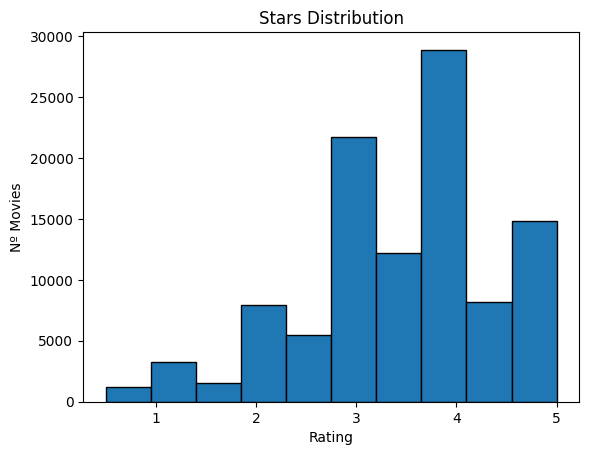

In [13]:
plt.hist(df['rating'], bins=10, edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Nº Movies')
plt.title('Stars Distribution')
plt.show()

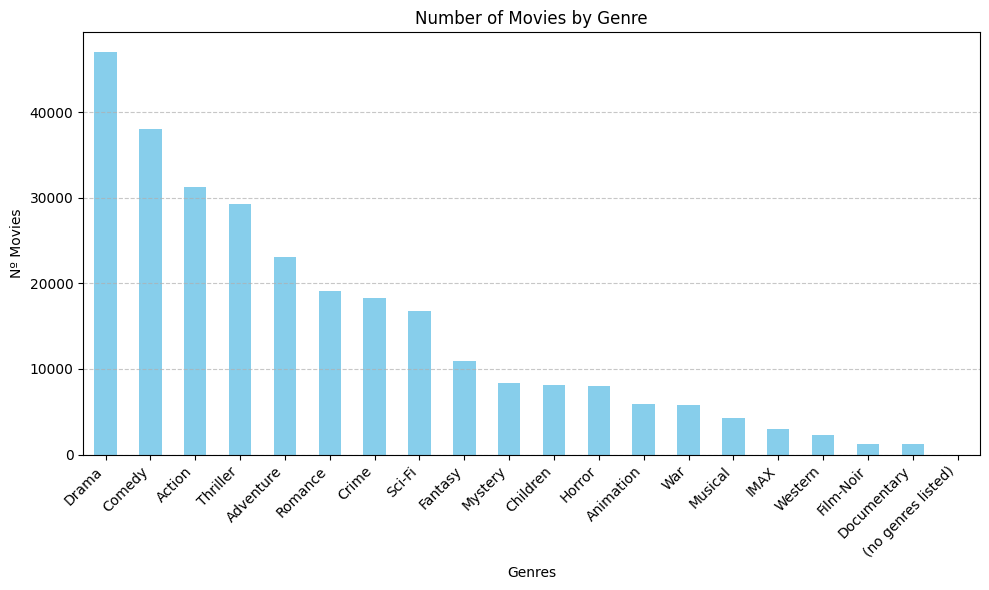

In [14]:
plt.figure(figsize=(10, 6))
genre_counts = df['genres'].str.split('|', expand=True).stack().value_counts()
genre_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Genres')
plt.ylabel('Nº Movies')
plt.title('Number of Movies by Genre')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


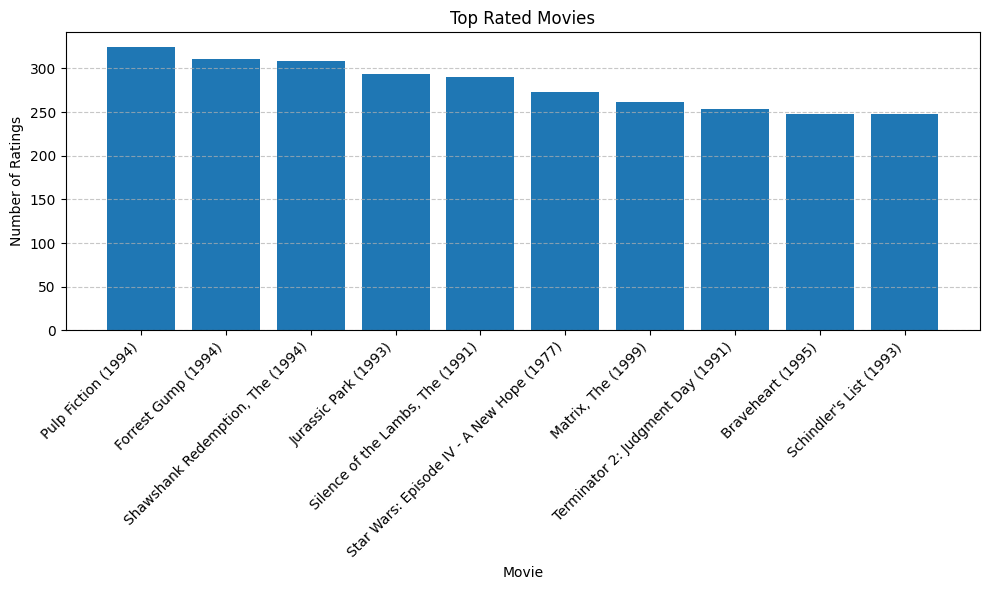

In [15]:
plt.figure(figsize=(10, 6))
top_movies = df.groupby('title')['rating'].count().nlargest(10)
plt.bar(top_movies.index, top_movies)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Movie')
plt.ylabel('Number of Ratings')
plt.title('Top Rated Movies')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

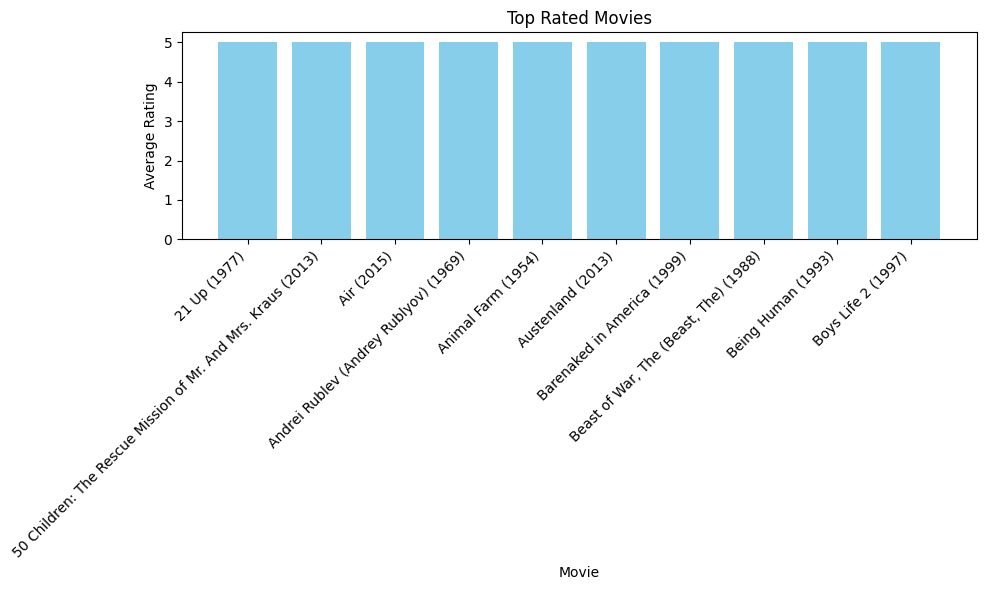

In [16]:
# Calcula el promedio de las calificaciones para cada película
avg_ratings = df.groupby('title')['rating'].mean()

# Selecciona las 10 películas con la calificación promedio más alta
top_rated_movies = avg_ratings.nlargest(10)

# Crea el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(top_rated_movies.index, top_rated_movies.values, color='skyblue')

# Ajusta las etiquetas del eje x para una mejor legibilidad
plt.xticks(rotation=45, ha='right')

# Etiqueta los ejes y el título
plt.xlabel('Movie')
plt.ylabel('Average Rating')
plt.title('Top Rated Movies')

# Muestra el gráfico
plt.tight_layout()
plt.show()

In [17]:
df.head()

,userId,movieId,rating,title,genres
0,1,16,4.0,Casino (1995),Crime|Drama
1,1,24,1.5,Powder (1995),Drama|Sci-Fi
2,1,32,4.0,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller
3,1,47,4.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,4.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [18]:
df= df.drop(columns=['title', 'genres'], inplace= True)

AttributeError: 'NoneType' object has no attribute 'info'

In [ ]:
X_train, X_test = train_test_split(df, test_size = 0.2, random_state = 42)

AttributeError: 'DataFrame' object has no attribute 'raw_ratings'

In [ ]:
model = KMeans(n_clusters = 6, n_init = "auto", random_state = 42)
model.fit(X_train)

y_train = list(model.labels_)
X_train["cluster"] = y_train
X_train.head()

,userId,movieId,rating,cluster
93148,614,1884,4.0,0
17873,137,55290,4.0,1
46130,328,2028,3.0,0
70228,475,61075,3.5,1
10717,89,597,3.0,0


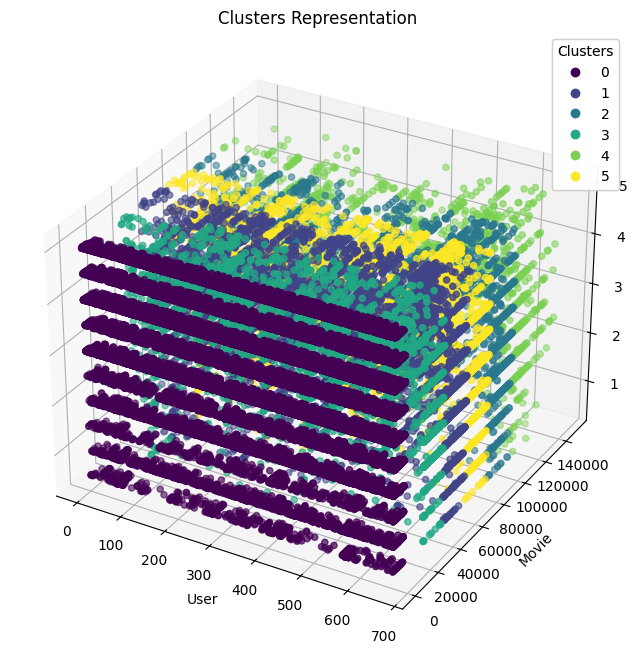